In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import pandas as pd

# import custom functions
from corrmat_functions import *

## Loading and preprocessing matrices

In [41]:
corrmats = load_all_corrmats()
tickers = load_corrmat_tickers()

In [42]:
#creating dictionary with not null corrleation matrices
#dictionary structure :
# { <timestamp> : { 
#       'corrmat' : <correleton_matrix>,
#       'tickers' : <tickers>
#   }
# }

notnull_corrmats = {}
for key in  corrmats.keys():
    notnullcorrmat, notnullcorrmat_tickers = notnull_corrmat_and_tickers(corrmats[key], tickers)
    notnull_corrmats[key] = {'corrmat' : notnullcorrmat, 'tickers' : notnullcorrmat_tickers}

In [43]:
def print_notnull_corrmats(notnull_corrmats):
    print_corrmats({x[0]:x[1]['corrmat'] for x in notnull_corrmats.items()})

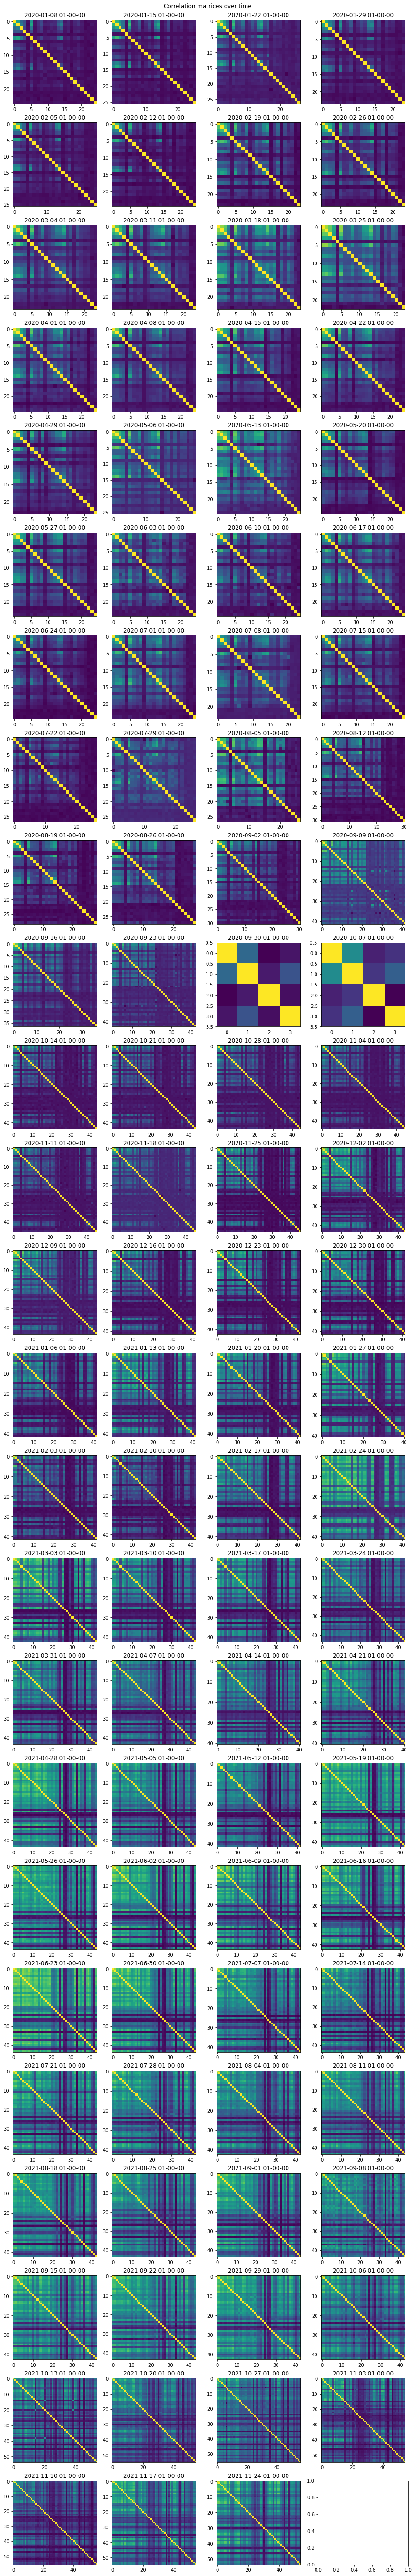

In [44]:
print_notnull_corrmats(notnull_corrmats)

## Denoising matrices

In [45]:
#loading Q values
Qs_theory = np.load('data/Qs_theory.npy', allow_pickle='TRUE').item()
Qs_mle = np.load('data/Qs_mle.npy', allow_pickle='TRUE').item()

# select which Q values to use (either MLE or theoretical limiting T/N)
Qs = Qs_mle

In [46]:
#takes a correlation matrix, Q , sigma and returns the denoised and rescaled correlation matrix

def get_denoised_correlation(correlation_matrix, Q, sigma):
    eigen_values, eigen_vectors = np.linalg.eig(correlation_matrix)

    N = len(eigen_values)

    eigen_value_min = sigma**2 * (1 + 1/Q - 2 * np.sqrt(1/Q))
    eigen_value_max = sigma**2 * (1 + 1/Q + 2 * np.sqrt(1/Q))

    filtered_eigen_values = [(eigen_value_max + eigen_value_min) / 2 if x < eigen_value_max else x for x in eigen_values]
    filtered_eigen_values_norm = [x / sum(filtered_eigen_values) * N for x in filtered_eigen_values]

    Y = eigen_vectors @ np.diag(filtered_eigen_values_norm) @ np.linalg.inv(eigen_vectors)

    d = [1 / (np.sqrt(x)) for x in Y.diagonal()]
    D = np.diag(d)

    Y_rescaled = D @ Y @ D

    return Y_rescaled

In [47]:
#creating dictionary with denoised non null correlation matrices
#dictionary structure :
# { <timestamp> : { 
#       'corrmat' : <correleton_matrix>,
#       'tickers' : <tickers>
#   }
# }

denoised_notnull_corrmats = {}

for k,v in notnull_corrmats.items():
    denoised_notnull_corrmats[k] = {'corrmat': get_denoised_correlation(v['corrmat'], Qs[k], 1), 'tickers': v['tickers']}

In [48]:
#this is the structure
#dictionary structure :
# { <timestamp> : { 
#       'corrmat' : <correleton_matrix>,
#       'tickers' : <tickers>
#   }
# }

np.save('data/denoised_notnull_corrmats.npy', denoised_notnull_corrmats)

#you load like this
#denoised_notnull_corrmats = np.load('data/denoised_notnull_corrmats.npy', allow_pickle='TRUE').item()

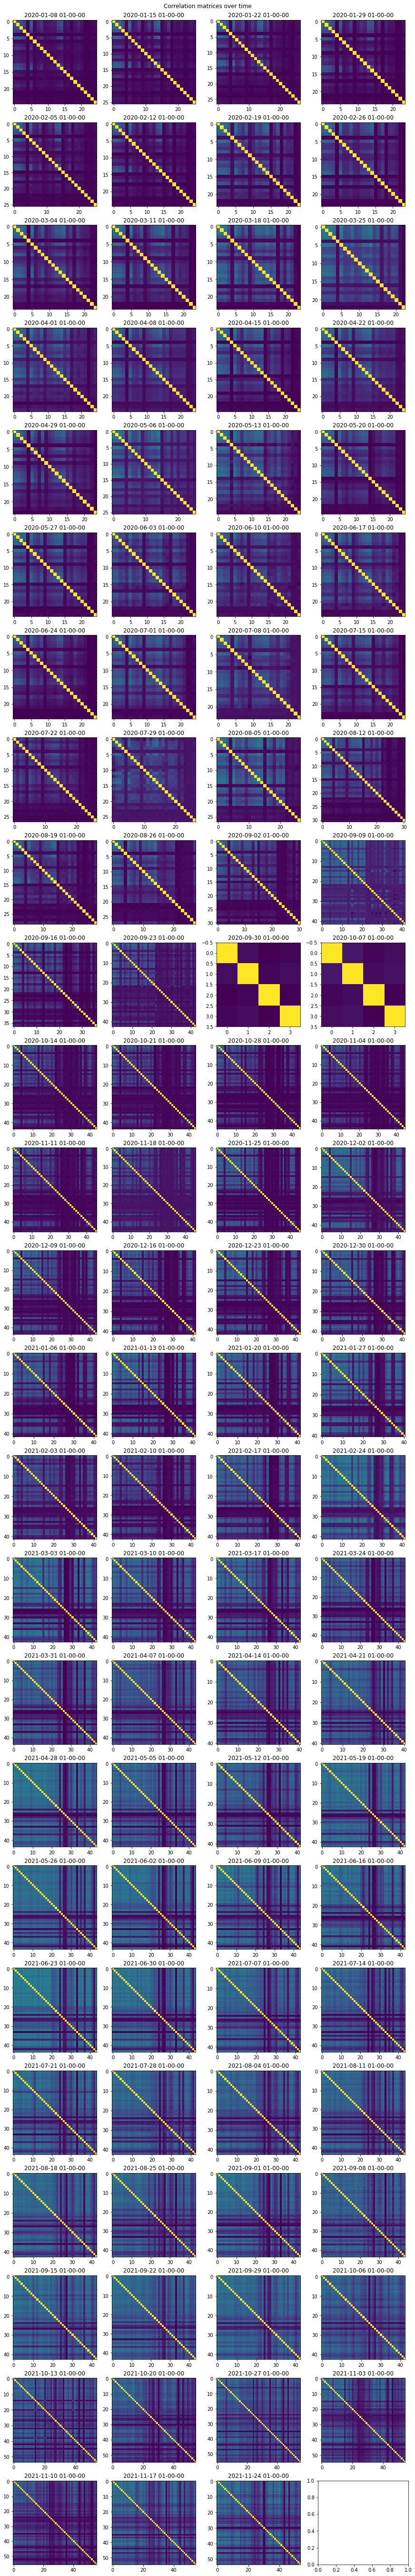

In [49]:
print_notnull_corrmats(denoised_notnull_corrmats)

## Generating MSTs

In [50]:
#generating mst from item of correlation matrix dictionary
#input structure :
# { 
#   'corrmat' : <correleton_matrix>,
#   'tickers' : <tickers>
# }

def generate_mst(correlation_matrix):
    D = np.sqrt(2 * np.round((1 - correlation_matrix["corrmat"]), 15))
    np.fill_diagonal(D, 0)

    mst = nx.minimum_spanning_tree(nx.from_numpy_array(D))

    #creating dictionary with index as keys to set node attributes
    tickers = {index: ticker for index, ticker in enumerate(correlation_matrix["tickers"])}
    nx.set_node_attributes(mst, tickers , 'ticker')
    nx.get_node_attributes(mst, 'ticker')

    return mst

In [51]:
#creting dictionary with all msts
# dictionary structure:
# { <timestamp> : <mst> }

msts = {}

for k,v in denoised_notnull_corrmats.items():
    msts[k] = generate_mst(v)


In [52]:
#wanted to test some things out so I use also noisy msts

#creting dictionary with all msts that are not denoised
# dictionary structure:
# { <timestamp> : <mst> }

noisy_msts = {}

for k,v in notnull_corrmats.items():
    noisy_msts[k] = generate_mst(v)

/var/folders/3s/3ns3k4_s6glc8ktbr60076q80000gn/T/ipykernel_6511/37905367.py:9: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(2 * np.round((1 - correlation_matrix["corrmat"]), 15))


In [53]:
#saving mst dictionaries to file

np.save('data/noisy_msts.npy', noisy_msts)
np.save('data/msts.npy', msts)

## Printing MSTs for exploration

In [54]:
#plot the mst with node size and color based on degree

def plot_mst(mst, timestamp):
    plt.figure(figsize=(8, 5))
    node_color = [nx.degree(mst)[n] for n in nx.nodes(mst)]
    node_size = [400 + nx.degree(mst)[n] * 20 for n in nx.nodes(mst)]
    pos = nx.kamada_kawai_layout(mst)
    #pos = nx.spring_layout(mst)
    nx.draw(mst, pos, node_color=node_color, cmap='Oranges', labels=nx.get_node_attributes(mst, 'ticker'), with_labels=True, node_size=node_size, font_size=8)
    plt.title(f"{timestamp}")
    plt.show()

In [55]:
# print all msts with input dictionary as :
# { <timestamp> : <mst> }

def print_msts(msts, n_cols=4):
    T = len(msts.keys())

    # dimensions of figure/plot grid
    n_cols = 4
    n_rows = int(np.ceil(T/n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4), constrained_layout=True)
    for cnt,timestamp in enumerate(sorted(msts.keys())):
        # determine axis
        col = cnt % n_cols
        row = cnt // n_cols
        ax = axs[row, col]

        # plot mst
        mst = msts[timestamp]

        node_color = [nx.degree(mst)[n] for n in nx.nodes(mst)]
        node_size = [200 + nx.degree(mst)[n] * 10 for n in nx.nodes(mst)]
        #pos = nx.kamada_kawai_layout(mst)
        pos = nx.spring_layout(mst, k=0.1)
        nx.draw(mst, pos, ax=ax, node_color=node_color, cmap='Oranges', labels=nx.get_node_attributes(mst, 'ticker'), with_labels=True, node_size=node_size, font_size=6)
        ax.set_title(timestamp)
        fig.suptitle("MSTs over time")

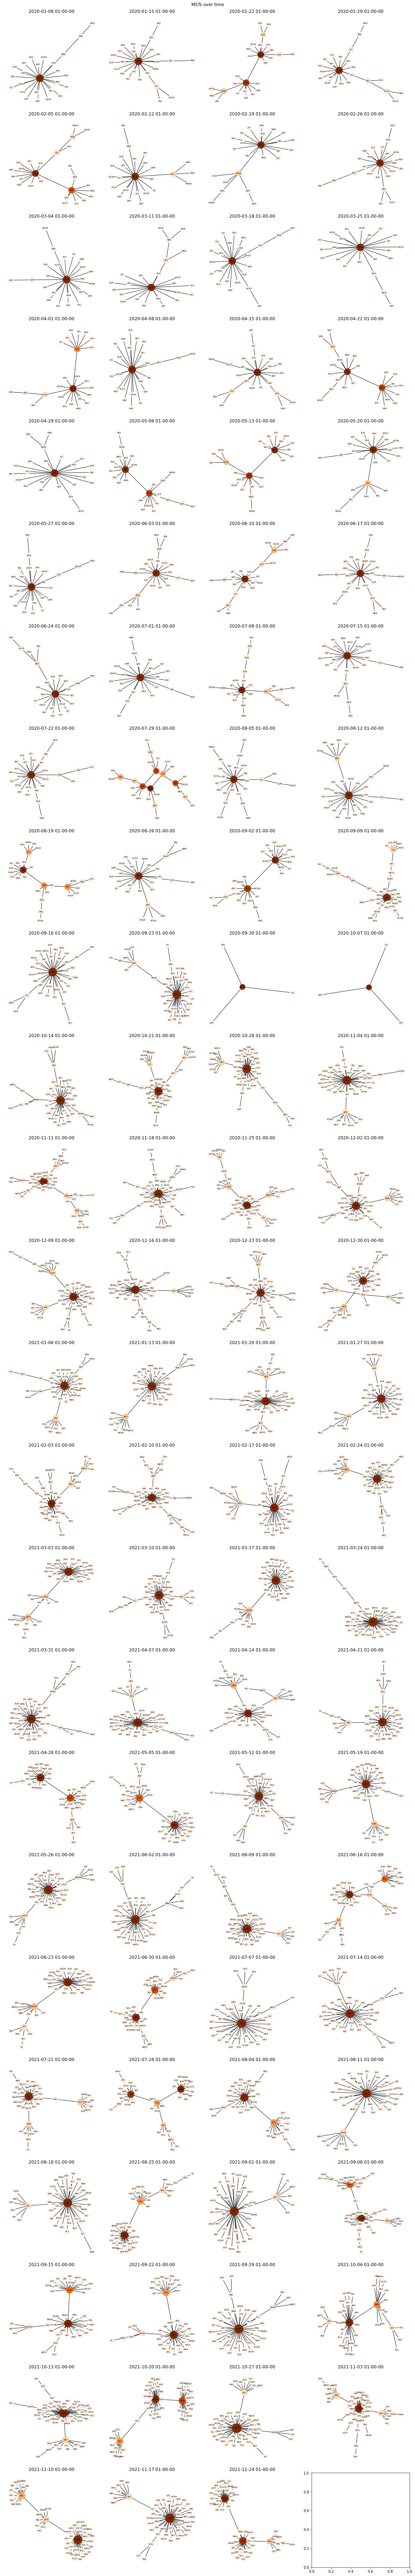

In [56]:
print_msts(msts)

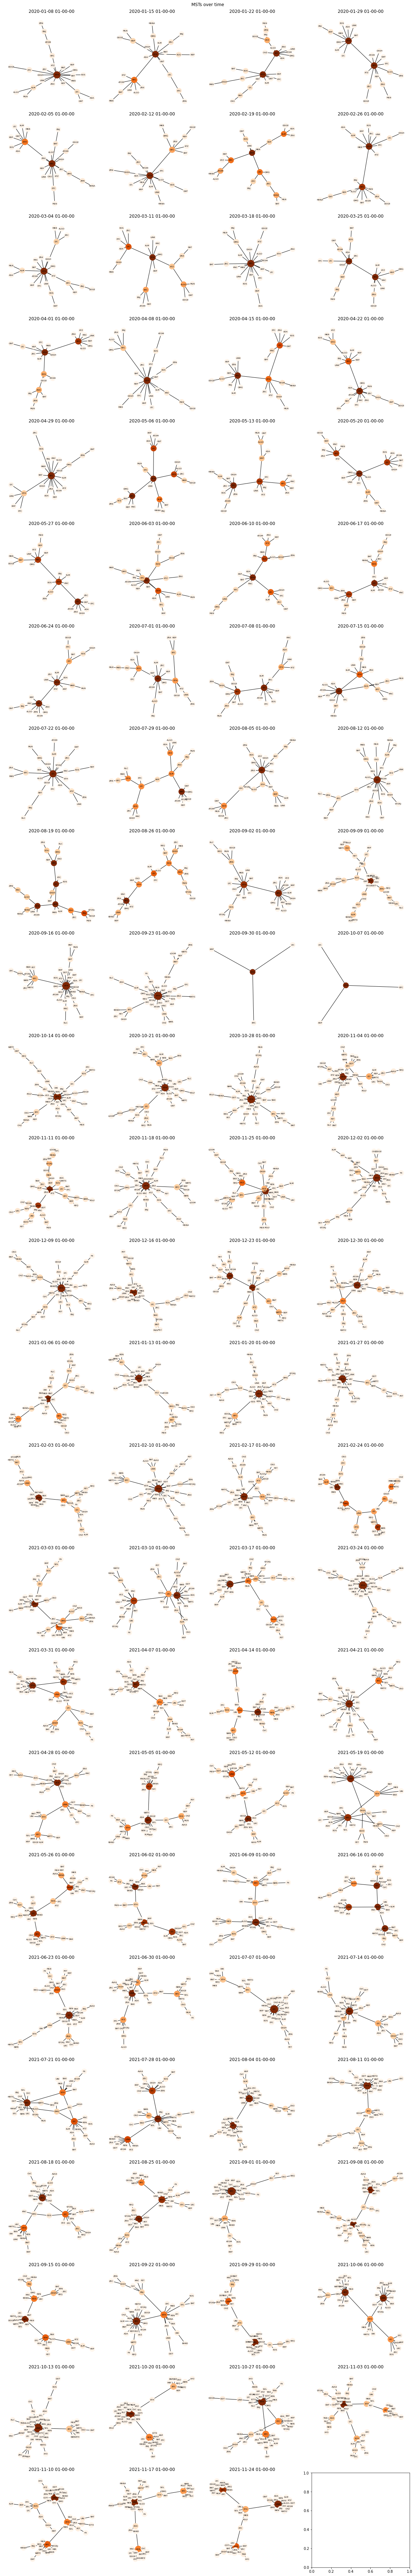

In [57]:
print_msts(noisy_msts)

[1, 22, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]


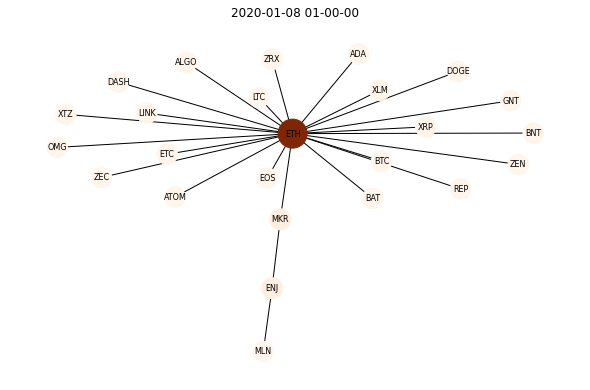

[2, 21, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]


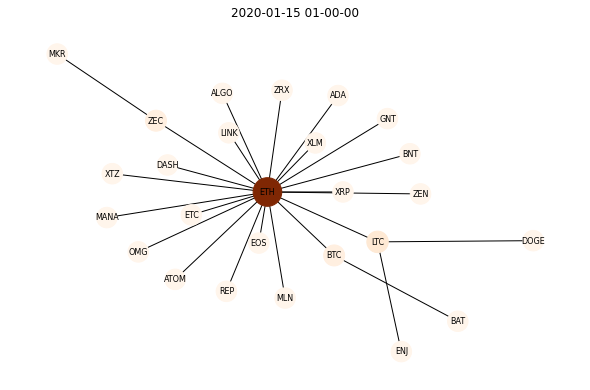

[11, 10, 1, 1, 1, 1, 2, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1]


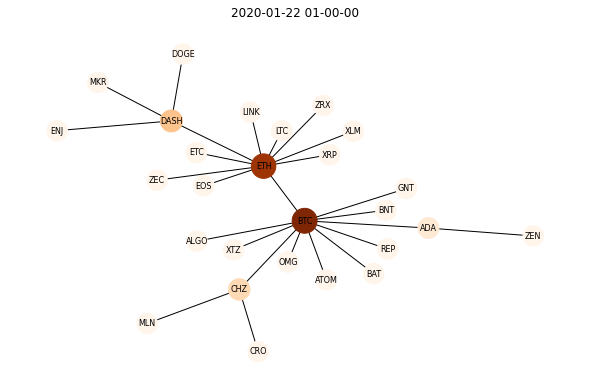

[3, 17, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]


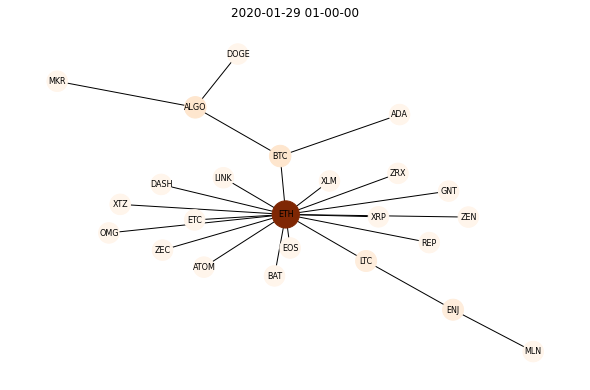

In [58]:
for k,mst in sorted(msts.items()):
    if k < "2020-02":
        print([x[1] for x in nx.degree(mst)])
        plot_mst(mst,k)


[2, 16, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1]


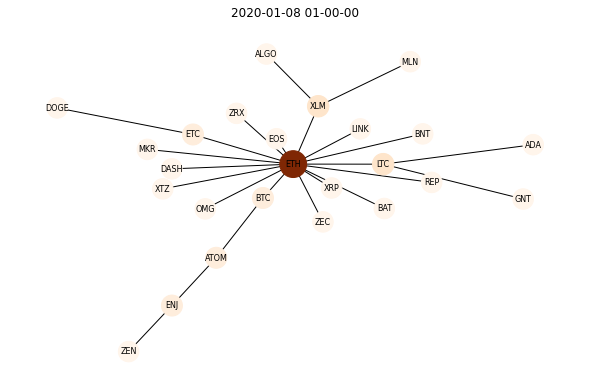

[7, 11, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1]


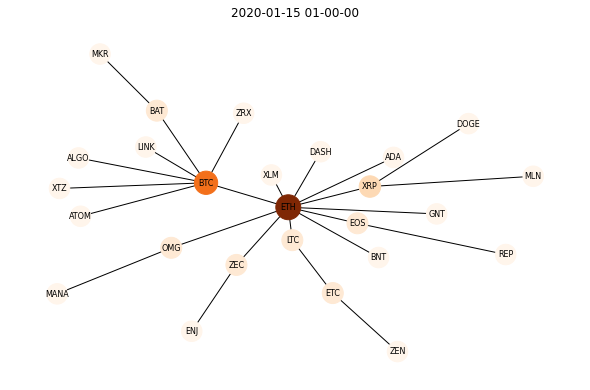

[9, 9, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 4, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1]


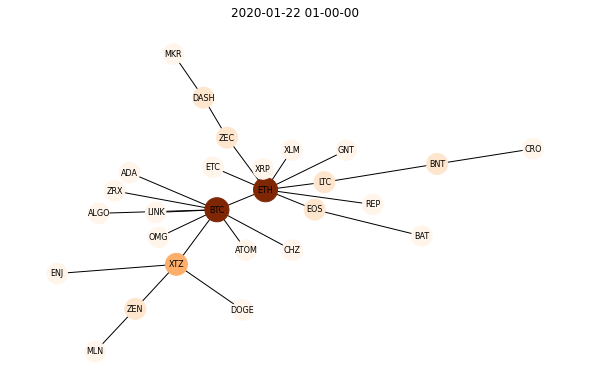

[10, 10, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]


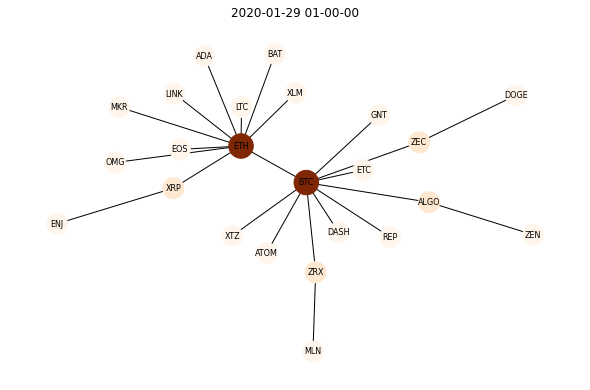

In [59]:
for k,mst in sorted(noisy_msts.items()):
    if k < "2020-02":
        print([x[1] for x in nx.degree(mst)])
        plot_mst(mst,k)

In [60]:
print(len(corrmats))
print(len(tickers))

99
57


In [61]:
degrees = np.zeros((len(corrmats), len(tickers)))

for i, (k,mst) in enumerate(sorted(msts.items())):
        #print(dict(nx.degree(mst)))
        #print(nx.get_node_attributes(mst,'ticker'))
        degree_per_ticker = dict(zip(nx.get_node_attributes(mst,'ticker').values(), dict(nx.degree(mst)).values()))
        #print(degree_per_ticker)
        for k,v in degree_per_ticker.items():
            degrees[i][tickers.index(k)] = v



degrees_mean = np.mean(degrees, axis=0)

In [62]:
degrees_df = pd.DataFrame(degrees)

rename_dict = {i:ticker for i,ticker in enumerate(tickers)}
degrees_df.rename(columns=rename_dict, inplace=True)

timestamps = [timestamp for timestamp in sorted(corrmats.keys())]
degrees_df.insert(0,'timestamps', timestamps)
degrees_df = degrees_df.set_index('timestamps')

In [63]:
degrees_df

BTC   ETH  XRP  XLM  DOGE  LTC  ADA  ZRX  LINK  MKR  \
timestamps                                                                  
2020-01-08 01-00-00   1.0  22.0  1.0  1.0   1.0  1.0  1.0  1.0   1.0  2.0   
2020-01-15 01-00-00   2.0  21.0  1.0  1.0   1.0  3.0  1.0  1.0   1.0  1.0   
2020-01-22 01-00-00  11.0  10.0  1.0  1.0   1.0  1.0  2.0  1.0   1.0  1.0   
2020-01-29 01-00-00   3.0  17.0  1.0  1.0   1.0  2.0  1.0  1.0   1.0  1.0   
2020-02-05 01-00-00   9.0  12.0  1.0  1.0   1.0  3.0  1.0  2.0   1.0  1.0   
...                   ...   ...  ...  ...   ...  ...  ...  ...   ...  ...   
2021-10-27 01-00-00   1.0  43.0  1.0  1.0   1.0  1.0  1.0  1.0   1.0  1.0   
2021-11-03 01-00-00   9.0   2.0  1.0  1.0   1.0  1.0  2.0  2.0  33.0  1.0   
2021-11-10 01-00-00  14.0   9.0  1.0  1.0   1.0  1.0  1.0  1.0  34.0  1.0   
2021-11-17 01-00-00   9.0   1.0  1.0  1.0   1.0  1.0  1.0  1.0  44.0  1.0   
2021-11-24 01-00-00  22.0   1.0  1.0  1.0   1.0  1.0  1.0  1.0  24.0  1.0   

                     ...  SOL  XYO  ANKR  COTI  NKN  QNT  IOTX  MIR  TRB  GTC  
timestamps           ...                                                       
2020-01-08 01-00-00  ...  0.0  0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  
2020-01-15 01-00-00  ...  0.0  0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  
2020-01-22 01-00-00  ...  0.0  0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  
2020-01-29 01-00-00  ...  0.0  0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  
2020-02-05 01-00-00  ...  0.0  0.0   0.0   0.0  0.0  0.0   0.0  0.0  0.0  0.0  
...                  ...  ...  ...   ...   ...  ...  ...   ...  ...  ...  ...  
2021-10-27 01-00-00  ...  1.0  1.0   1.0   1.0  1.0  1.0   1.0  1.0  1.0  1.0  
2021-11-03 01-00-00  ...  1.0  1.0   1.0   1.0  1.0  1.0   1.0  1.0  1.0  1.0  
2021-11-10 01-00-00  ...  1.0  1.0   1.0   1.0  1.0  1.0   1.0  1.0  1.0  1.0  
2021-11-17 01-00-00  ...  1.0  1.0   1.0   1.0  1.0  1.0   0.0  1.0  1.0  1.0  
2021-11-24 01-00-00  ...  1.0  1.0   1.0   1.0  1.0  1.0   0.0  1.0  1.0  1.0  

[99 rows x 57 columns]

In [64]:
#export degrees dataframe to file
degrees_df.to_csv('data/degrees.csv')

<AxesSubplot:xlabel='timestamps'>

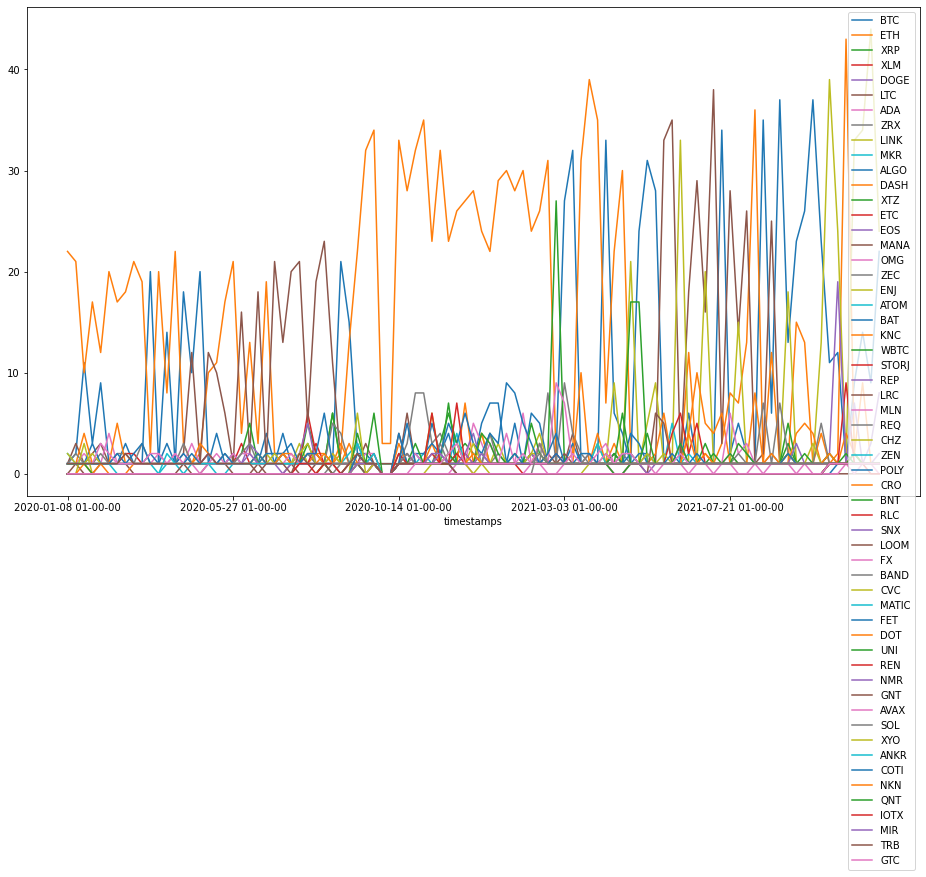

In [65]:
degrees_df.plot(figsize=(16,9))

In [66]:
degrees_noisy = np.zeros((len(corrmats), len(tickers)))

for i, (k,mst) in enumerate(sorted(noisy_msts.items())):
        #print(dict(nx.degree(mst)))
        #print(nx.get_node_attributes(mst,'ticker'))
        degree_per_ticker = dict(zip(nx.get_node_attributes(mst,'ticker').values(), dict(nx.degree(mst)).values()))
        #print(degree_per_ticker)
        for k,v in degree_per_ticker.items():
            degrees_noisy[i][tickers.index(k)] = v


In [67]:
degrees_noisy_df = pd.DataFrame(degrees_noisy)

rename_dict = {i:ticker for i,ticker in enumerate(tickers)}
degrees_noisy_df.rename(columns=rename_dict, inplace=True)

timestamps = [timestamp for timestamp in sorted(corrmats.keys())]
degrees_noisy_df.insert(0,'timestamps', timestamps)
degrees_noisy_df = degrees_noisy_df.set_index('timestamps')

<AxesSubplot:xlabel='timestamps'>

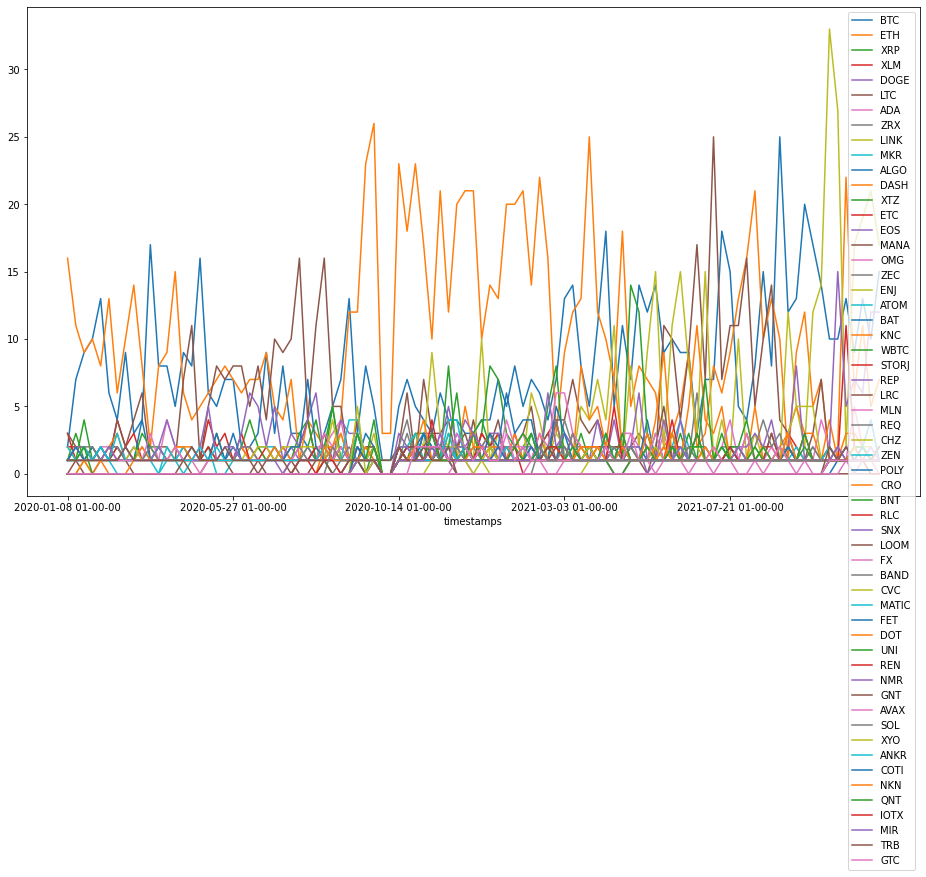

In [68]:
degrees_noisy_df.plot(figsize=(16,9))

In [69]:
from IPython.display import clear_output
from time import sleep

#plt.figure()
#for k,mst in sorted(noisy_msts.items()):
#    if k < "2021":
#        plot_mst(mst,k)
#        sleep(1)
#        clear_output(wait=True)


In [70]:
nx.get_node_attributes(mst, 'ticker').items()

dict_items([(0, 'BTC'), (1, 'ETH'), (2, 'XRP'), (3, 'XLM'), (4, 'DOGE'), (5, 'LTC'), (6, 'ADA'), (7, 'ZRX'), (8, 'LINK'), (9, 'MKR'), (10, 'ALGO'), (11, 'DASH'), (12, 'XTZ'), (13, 'ETC'), (14, 'EOS'), (15, 'MANA'), (16, 'OMG'), (17, 'ZEC'), (18, 'ENJ'), (19, 'ATOM'), (20, 'BAT'), (21, 'KNC'), (22, 'WBTC'), (23, 'STORJ'), (24, 'REP'), (25, 'LRC'), (26, 'MLN'), (27, 'REQ'), (28, 'CHZ'), (29, 'ZEN'), (30, 'POLY'), (31, 'CRO'), (32, 'BNT'), (33, 'RLC'), (34, 'SNX'), (35, 'BAND'), (36, 'CVC'), (37, 'MATIC'), (38, 'FET'), (39, 'DOT'), (40, 'UNI'), (41, 'REN'), (42, 'NMR'), (43, 'GNT'), (44, 'AVAX'), (45, 'SOL'), (46, 'XYO'), (47, 'ANKR'), (48, 'COTI'), (49, 'NKN'), (50, 'QNT'), (51, 'MIR'), (52, 'TRB'), (53, 'GTC')])

In [71]:
list(nx.generate_edgelist(mst))

["0 1 {'weight': 0.531710841987007}",
 "0 5 {'weight': 0.6331415474591586}",
 "0 4 {'weight': 0.7881073446432028}",
 "0 32 {'weight': 0.9776439250156133}",
 "0 38 {'weight': 1.0371980027635872}",
 "0 47 {'weight': 1.0418574215188037}",
 "0 15 {'weight': 1.1137943347757988}",
 "0 22 {'weight': 1.1310150882705243}",
 "0 42 {'weight': 1.1424136117457713}",
 "0 25 {'weight': 1.148012385065257}",
 "0 31 {'weight': 1.1501987470065067}",
 "0 27 {'weight': 1.187208560436744}",
 "0 50 {'weight': 1.193387266416282}",
 "0 51 {'weight': 1.2140373561926223}",
 "0 26 {'weight': 1.2444142366403705}",
 "1 8 {'weight': 0.6247508793257981}",
 "1 13 {'weight': 0.7051271788503872}",
 "1 40 {'weight': 0.7094221605729144}",
 "1 45 {'weight': 0.7470725189957519}",
 "1 34 {'weight': 0.7780426324931404}",
 "1 9 {'weight': 1.0738153596573343}",
 "2 14 {'weight': 0.8142298881346779}",
 "3 8 {'weight': 0.7834313236282157}",
 "6 8 {'weight': 0.6990720186565931}",
 "7 8 {'weight': 0.9544275619506207}",
 "8 39 {'wei

In [72]:
list(dict(mst.edges()).keys())[0]

(0, 1)

In [73]:
[{'source': tickers.index(nx.get_node_attributes(mst, 'ticker')[source]), 'target': tickers.index(nx.get_node_attributes(mst, 'ticker')[target]), 'weight': v} for (source,target),v in dict(mst.edges()).items()]

[{'source': 0, 'target': 1, 'weight': {'weight': 0.531710841987007}},
 {'source': 0, 'target': 5, 'weight': {'weight': 0.6331415474591586}},
 {'source': 0, 'target': 4, 'weight': {'weight': 0.7881073446432028}},
 {'source': 0, 'target': 32, 'weight': {'weight': 0.9776439250156133}},
 {'source': 0, 'target': 40, 'weight': {'weight': 1.0371980027635872}},
 {'source': 0, 'target': 49, 'weight': {'weight': 1.0418574215188037}},
 {'source': 0, 'target': 15, 'weight': {'weight': 1.1137943347757988}},
 {'source': 0, 'target': 22, 'weight': {'weight': 1.1310150882705243}},
 {'source': 0, 'target': 44, 'weight': {'weight': 1.1424136117457713}},
 {'source': 0, 'target': 25, 'weight': {'weight': 1.148012385065257}},
 {'source': 0, 'target': 31, 'weight': {'weight': 1.1501987470065067}},
 {'source': 0, 'target': 27, 'weight': {'weight': 1.187208560436744}},
 {'source': 0, 'target': 52, 'weight': {'weight': 1.193387266416282}},
 {'source': 0, 'target': 54, 'weight': {'weight': 1.2140373561926223}},

In [74]:
mst_over_time = {'nodes':[], 'edges':[]}

for k,mst in msts.items():
    if k < '2020-02':
        mst_over_time['nodes'] += [{'id': tickers.index(ticker), 'ticker': ticker, "timestamp": k} for i,ticker in nx.get_node_attributes(mst, 'ticker').items()]
        mst_over_time['edges'] += [{'source': tickers.index(nx.get_node_attributes(mst, 'ticker')[source]), 'target': tickers.index(nx.get_node_attributes(mst, 'ticker')[target]), 'timestamp': k, 'weight': v['weight']} for (source,target),v in dict(mst.edges()).items()]

mst_over_time


{'nodes': [{'id': 0, 'ticker': 'BTC', 'timestamp': '2020-01-08 01-00-00'},
  {'id': 1, 'ticker': 'ETH', 'timestamp': '2020-01-08 01-00-00'},
  {'id': 2, 'ticker': 'XRP', 'timestamp': '2020-01-08 01-00-00'},
  {'id': 3, 'ticker': 'XLM', 'timestamp': '2020-01-08 01-00-00'},
  {'id': 4, 'ticker': 'DOGE', 'timestamp': '2020-01-08 01-00-00'},
  {'id': 5, 'ticker': 'LTC', 'timestamp': '2020-01-08 01-00-00'},
  {'id': 6, 'ticker': 'ADA', 'timestamp': '2020-01-08 01-00-00'},
  {'id': 7, 'ticker': 'ZRX', 'timestamp': '2020-01-08 01-00-00'},
  {'id': 8, 'ticker': 'LINK', 'timestamp': '2020-01-08 01-00-00'},
  {'id': 9, 'ticker': 'MKR', 'timestamp': '2020-01-08 01-00-00'},
  {'id': 10, 'ticker': 'ALGO', 'timestamp': '2020-01-08 01-00-00'},
  {'id': 11, 'ticker': 'DASH', 'timestamp': '2020-01-08 01-00-00'},
  {'id': 12, 'ticker': 'XTZ', 'timestamp': '2020-01-08 01-00-00'},
  {'id': 13, 'ticker': 'ETC', 'timestamp': '2020-01-08 01-00-00'},
  {'id': 14, 'ticker': 'EOS', 'timestamp': '2020-01-08 01-0

In [75]:
mst_over_time_by_timestamp = {}

for k,mst in msts.items():
    if k < '2020-02':
        mst_over_time_by_timestamp[k] = {
            'nodes': [{'id': tickers.index(ticker), 'ticker': ticker} for i,ticker in nx.get_node_attributes(mst, 'ticker').items()],
            'edges': [{'source': tickers.index(nx.get_node_attributes(mst, 'ticker')[source]), 'target': tickers.index(nx.get_node_attributes(mst, 'ticker')[target]), 'weight': v['weight']} for (source,target),v in dict(mst.edges()).items()]
        }
mst_over_time_by_timestamp

{'2020-01-08 01-00-00': {'nodes': [{'id': 0, 'ticker': 'BTC'},
   {'id': 1, 'ticker': 'ETH'},
   {'id': 2, 'ticker': 'XRP'},
   {'id': 3, 'ticker': 'XLM'},
   {'id': 4, 'ticker': 'DOGE'},
   {'id': 5, 'ticker': 'LTC'},
   {'id': 6, 'ticker': 'ADA'},
   {'id': 7, 'ticker': 'ZRX'},
   {'id': 8, 'ticker': 'LINK'},
   {'id': 9, 'ticker': 'MKR'},
   {'id': 10, 'ticker': 'ALGO'},
   {'id': 11, 'ticker': 'DASH'},
   {'id': 12, 'ticker': 'XTZ'},
   {'id': 13, 'ticker': 'ETC'},
   {'id': 14, 'ticker': 'EOS'},
   {'id': 16, 'ticker': 'OMG'},
   {'id': 17, 'ticker': 'ZEC'},
   {'id': 18, 'ticker': 'ENJ'},
   {'id': 19, 'ticker': 'ATOM'},
   {'id': 20, 'ticker': 'BAT'},
   {'id': 24, 'ticker': 'REP'},
   {'id': 26, 'ticker': 'MLN'},
   {'id': 29, 'ticker': 'ZEN'},
   {'id': 32, 'ticker': 'BNT'},
   {'id': 45, 'ticker': 'GNT'}],
  'edges': [{'source': 0, 'target': 1, 'weight': 1.1946251565082748},
   {'source': 1, 'target': 5, 'weight': 1.1827851608209414},
   {'source': 1, 'target': 14, 'weight': 